## Plot variables at the 3.6, 4.5, 5.8, 8.0 and 10.5 micrometer photospheres

In [1]:
import warnings
from pathlib import Path

import iris
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import LogNorm
from tqdm.notebook import tqdm as tqdm

In [2]:
from aeolus.coord import interp_cube_from_height_to_pressure_levels
from aeolus.synthobs import read_spectral_bands

In [3]:
from util_commons import GASES, PLANETS, SUITES
from util_mypaths import path_to_processed, path_to_results
from util_plot_func import use_paper_style

In [4]:
warnings.filterwarnings("ignore", module="iris")
warnings.filterwarnings("ignore", module="aeolus")
use_paper_style()

In [5]:
# Input parameters
metallicity = "1x solar"
tgt_plevs = np.logspace(7, 2, 65)  # target pressure levels

In [6]:
# Read spectral bands from the SOCRATES spectral file
# (band numbering and bounds are the same for HAT-P-11b, HD 189733b, HD 209458b and WASP-17b)
path_to_star_spectrum_lw = SUITES["hatp11b"]["equilibrium"][metallicity]["dir_for_star_spectrum_lw"]
socrates_bands = read_spectral_bands(path_to_star_spectrum_lw)
# SOCRATES bands corresponding to the center of the Spitzer/IRAC 3.6, 4.5, 5.8 and 8.0 micrometer channels,
# and an extra band for 10.5 micrometers containing an NH3 feature
BANDS = {
    "3.6": {
        "species": "ch4",
        "index": 278,
        "bounds_socrates": (socrates_bands[277][1], socrates_bands[277][2]),
        "bounds_spitzer_irac": (3.081060, 4.010380),
    },
    "4.5": {
        "species": "co",
        "index": 223,
        "bounds_socrates": (socrates_bands[222][1], socrates_bands[222][2]),
        "bounds_spitzer_irac": (3.722490, 5.221980),
    },
    "5.8": {
        "species": "h2o",
        "index": 173,
        "bounds_socrates": (socrates_bands[172][1], socrates_bands[172][2]),
        "bounds_spitzer_irac": (4.744210, 6.622510),
    },
    "8.0": {
        "species": "ch4",
        "index": 125,
        "bounds_socrates": (socrates_bands[124][1], socrates_bands[124][2]),
        "bounds_spitzer_irac": (6.151150, 9.728750),
    },
    "10.5": {
        "species": "nh3",
        "index": 96,
        "bounds_socrates": (socrates_bands[95][1], socrates_bands[95][2]),
        "bounds_spitzer_irac": (socrates_bands[95][1] * 1e6, socrates_bands[95][2] * 1e6),
    },
}

In [7]:
vrbls = {}
for planet in tqdm(PLANETS.keys()):
    vrbls[planet] = {}
    for exp in ["equilibrium", "kinetics"]:
        vrbls[planet][exp] = {}
        # Load the last time step
        fname1 = f"{SUITES[planet][exp][metallicity]['rose_suite']}.nc"
        path_to_merged = SUITES[planet][exp][metallicity]["dir_for_merged"]
        pressure = iris.load_cube(str(path_to_merged / fname1), "air_pressure")[-1, ...]
        temperature = iris.load_cube(str(path_to_merged / fname1), "air_temperature")[-1, ...]
        ch4 = iris.load_cube(str(path_to_merged / fname1), "CH4 mole fraction")[-1, ...]
        co = iris.load_cube(str(path_to_merged / fname1), "CO mole fraction")[-1, ...]
        h2o = iris.load_cube(str(path_to_merged / fname1), "H2O mole fraction")[-1, ...]
        nh3 = iris.load_cube(str(path_to_merged / fname1), "NH3 mole fraction")[-1, ...]
        # Relevel to pressure levels
        pres_plevs = interp_cube_from_height_to_pressure_levels(pressure, pressure, tgt_plevs)
        temp_plevs = interp_cube_from_height_to_pressure_levels(temperature, pressure, tgt_plevs)
        ch4_plevs = interp_cube_from_height_to_pressure_levels(ch4, pressure, tgt_plevs)
        co_plevs = interp_cube_from_height_to_pressure_levels(co, pressure, tgt_plevs)
        h2o_plevs = interp_cube_from_height_to_pressure_levels(h2o, pressure, tgt_plevs)
        nh3_plevs = interp_cube_from_height_to_pressure_levels(nh3, pressure, tgt_plevs)
        # Order chemical species by band
        band_sp_order = [ch4_plevs, co_plevs, h2o_plevs, ch4_plevs, nh3_plevs]
        for (band, band_dict), sp_order in zip(BANDS.items(), band_sp_order):
            vrbls[planet][exp][band] = {}
            band_in_nm = int(float(band) * 1e3)
            fname2 = f"{planet}_{exp[0:3]}_flux_con_func_{band_in_nm}_nm.nc"
            vname = f"normalised_flux_contribution_function_on_pressure_levels_at_{band_in_nm}_nm"
            norm_con_func = iris.load_cube(
                str(
                    path_to_processed
                    / planet
                    / exp
                    / "flux_contribution_function_lw_spitzer"
                    / fname2
                ),
                vname,
            )
            # Pressure, temperature and chemical species mole fraction
            # sampled at a pressure level where the normilised contribution function is equal to one
            # in the band where this chemical species has an absorbtion feature
            pres = np.nansum(
                np.where(
                    norm_con_func.data == 1,
                    pres_plevs.data,
                    np.nan,
                ),
                axis=0,
            )
            temp = np.nansum(
                np.where(
                    norm_con_func.data == 1,
                    temp_plevs.data,
                    np.nan,
                ),
                axis=0,
            )
            sp = np.nansum(
                np.where(
                    norm_con_func.data == 1,
                    sp_order.data,
                    np.nan,
                ),
                axis=0,
            )
            # Assemble data
            vrbls[planet][exp][band] = {
                "pres": pres,
                "temp": temp,
                f"{band_dict['species']}": sp,
            }

  0%|          | 0/4 [00:00<?, ?it/s]

In [16]:
vrs = ["pres", "temp", "ch4", "co", "h2o", "nh3"]
# Find common bounds for each variable within each planet
bounds_by_planet = {}
for planet in PLANETS.keys():
    bounds_by_planet[planet] = {}
    for band in BANDS.keys():
        bounds_by_planet[planet][band] = {}
        for vr in vrs:
            if vr in vrbls[planet][exp][band].keys():
                bounds_by_planet[planet][band][vr] = {}
                vr_mins = []
                vr_maxs = []
                for exp in ["equilibrium", "kinetics"]:
                    vr_mins.append(np.min(vrbls[planet][exp][band][vr]))
                    vr_maxs.append(np.max(vrbls[planet][exp][band][vr]))
                bounds_by_planet[planet][band][vr] = {
                    "min": np.min(vr_mins),
                    "max": np.max(vr_maxs),
                }
# Find common bounds for each variable across all planets
bounds_by_var = {}
for vr in vrs:
    mins_by_var = []
    maxs_by_var = []
    for planet in PLANETS.keys():
        for exp in ["equilibrium", "kinetics"]:
            for band in BANDS.keys():
                if vr in vrbls[planet][exp][band].keys():
                    bounds_by_var[vr] = {}
                    mins_by_var.append(np.min(vrbls[planet][exp][band][vr]))
                    maxs_by_var.append(np.max(vrbls[planet][exp][band][vr]))
                    bounds_by_var[vr] = {
                        "min": np.min(mins_by_var),
                        "max": np.max(maxs_by_var),
                    }

In [17]:
# Plotting parameters
lons = pressure.coord("longitude").points
lats = pressure.coord("latitude").points
pres_kwargs = {"cmap": "Blues", "shading": "auto"}
temp_kwargs = {"cmap": "Reds", "shading": "auto"}
chem_kwargs = {"cmap": "Purples", "shading": "auto"}

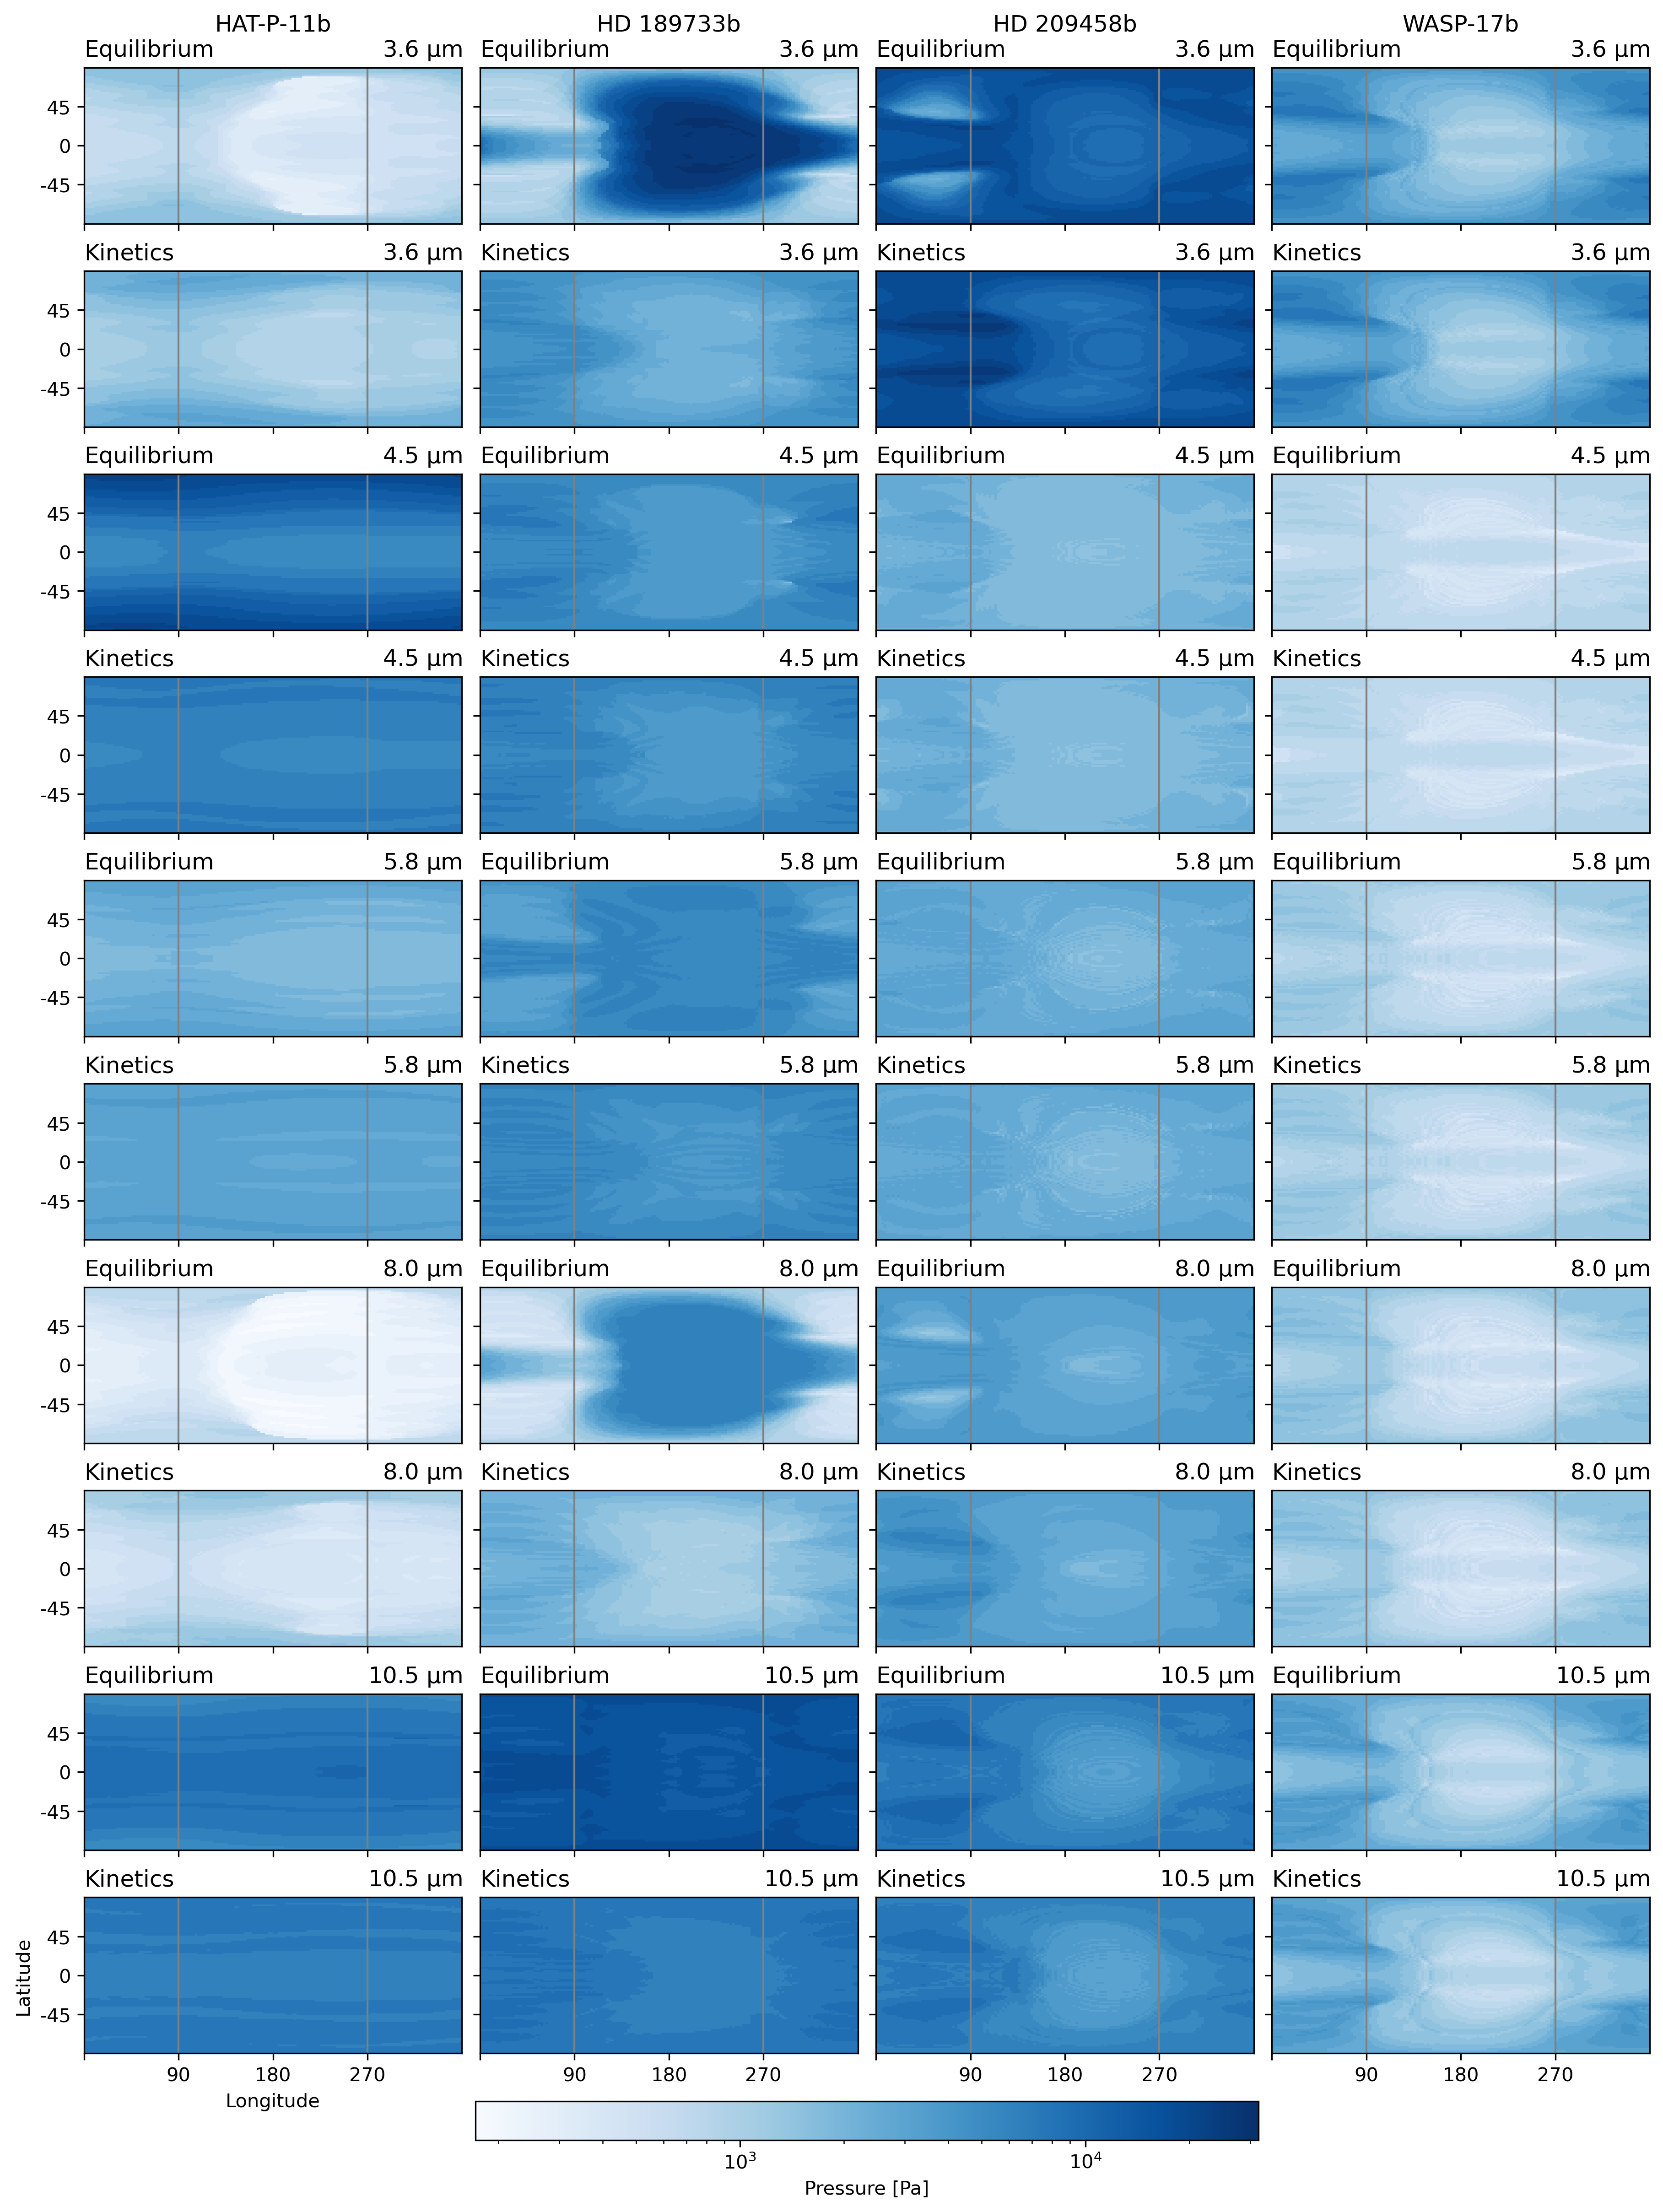

In [19]:
fig, axes = plt.subplots(
    figsize=(12, 16),
    nrows=10,
    ncols=4,
    sharex=True,
    sharey=True,
    facecolor="w",
    constrained_layout=True,
)
for planet, axcol in zip(PLANETS.keys(), axes.T):
    for (exp, band), ax in zip(
        [(exp, band) for band in BANDS.keys() for exp in ["equilibrium", "kinetics"]], axcol
    ):
        ax.set_title(f"{exp.capitalize()}", loc="left")
        ax.set_title(f"{band} $\mu$m", loc="right")
        p0 = ax.pcolormesh(
            lons,
            lats,
            vrbls[planet][exp][band]["pres"],
            norm=LogNorm(
                vmin=bounds_by_var["pres"]["min"],
                vmax=bounds_by_var["pres"]["max"],
            ),
            **pres_kwargs,
        )
        if ax.get_subplotspec().is_first_row():
            ax.set_title(f"{PLANETS[planet]['tex']}\n", loc="center")
        if ax.get_subplotspec().is_last_row():
            if ax.get_subplotspec().is_first_col():
                ax.set_xlabel("Longitude")
                ax.set_ylabel("Latitude")
        ax.set_xticks(
            [
                0,
                90,
                180,
                270,
            ]
        )
        ax.set_xticklabels(
            [
                None,
                90,
                180,
                270,
            ]
        )
        ax.axvline(x=90, color="grey", linewidth=1)
        ax.axvline(x=270, color="grey", linewidth=1)
        ax.set_yticks([-45, 0, 45])
        ax.set_yticklabels([-45, 0, 45])
cbar = fig.colorbar(
    p0, ax=axes, label="Pressure [Pa]", orientation="horizontal", shrink=0.5, pad=-0.005
)
cbar.ax.invert_yaxis()
fig.savefig(
    path_to_results / "photosphere_spitzer" / f"pres_at_lw_norm_flux_con_func_of_unity.png",
    bbox_inches="tight",
)

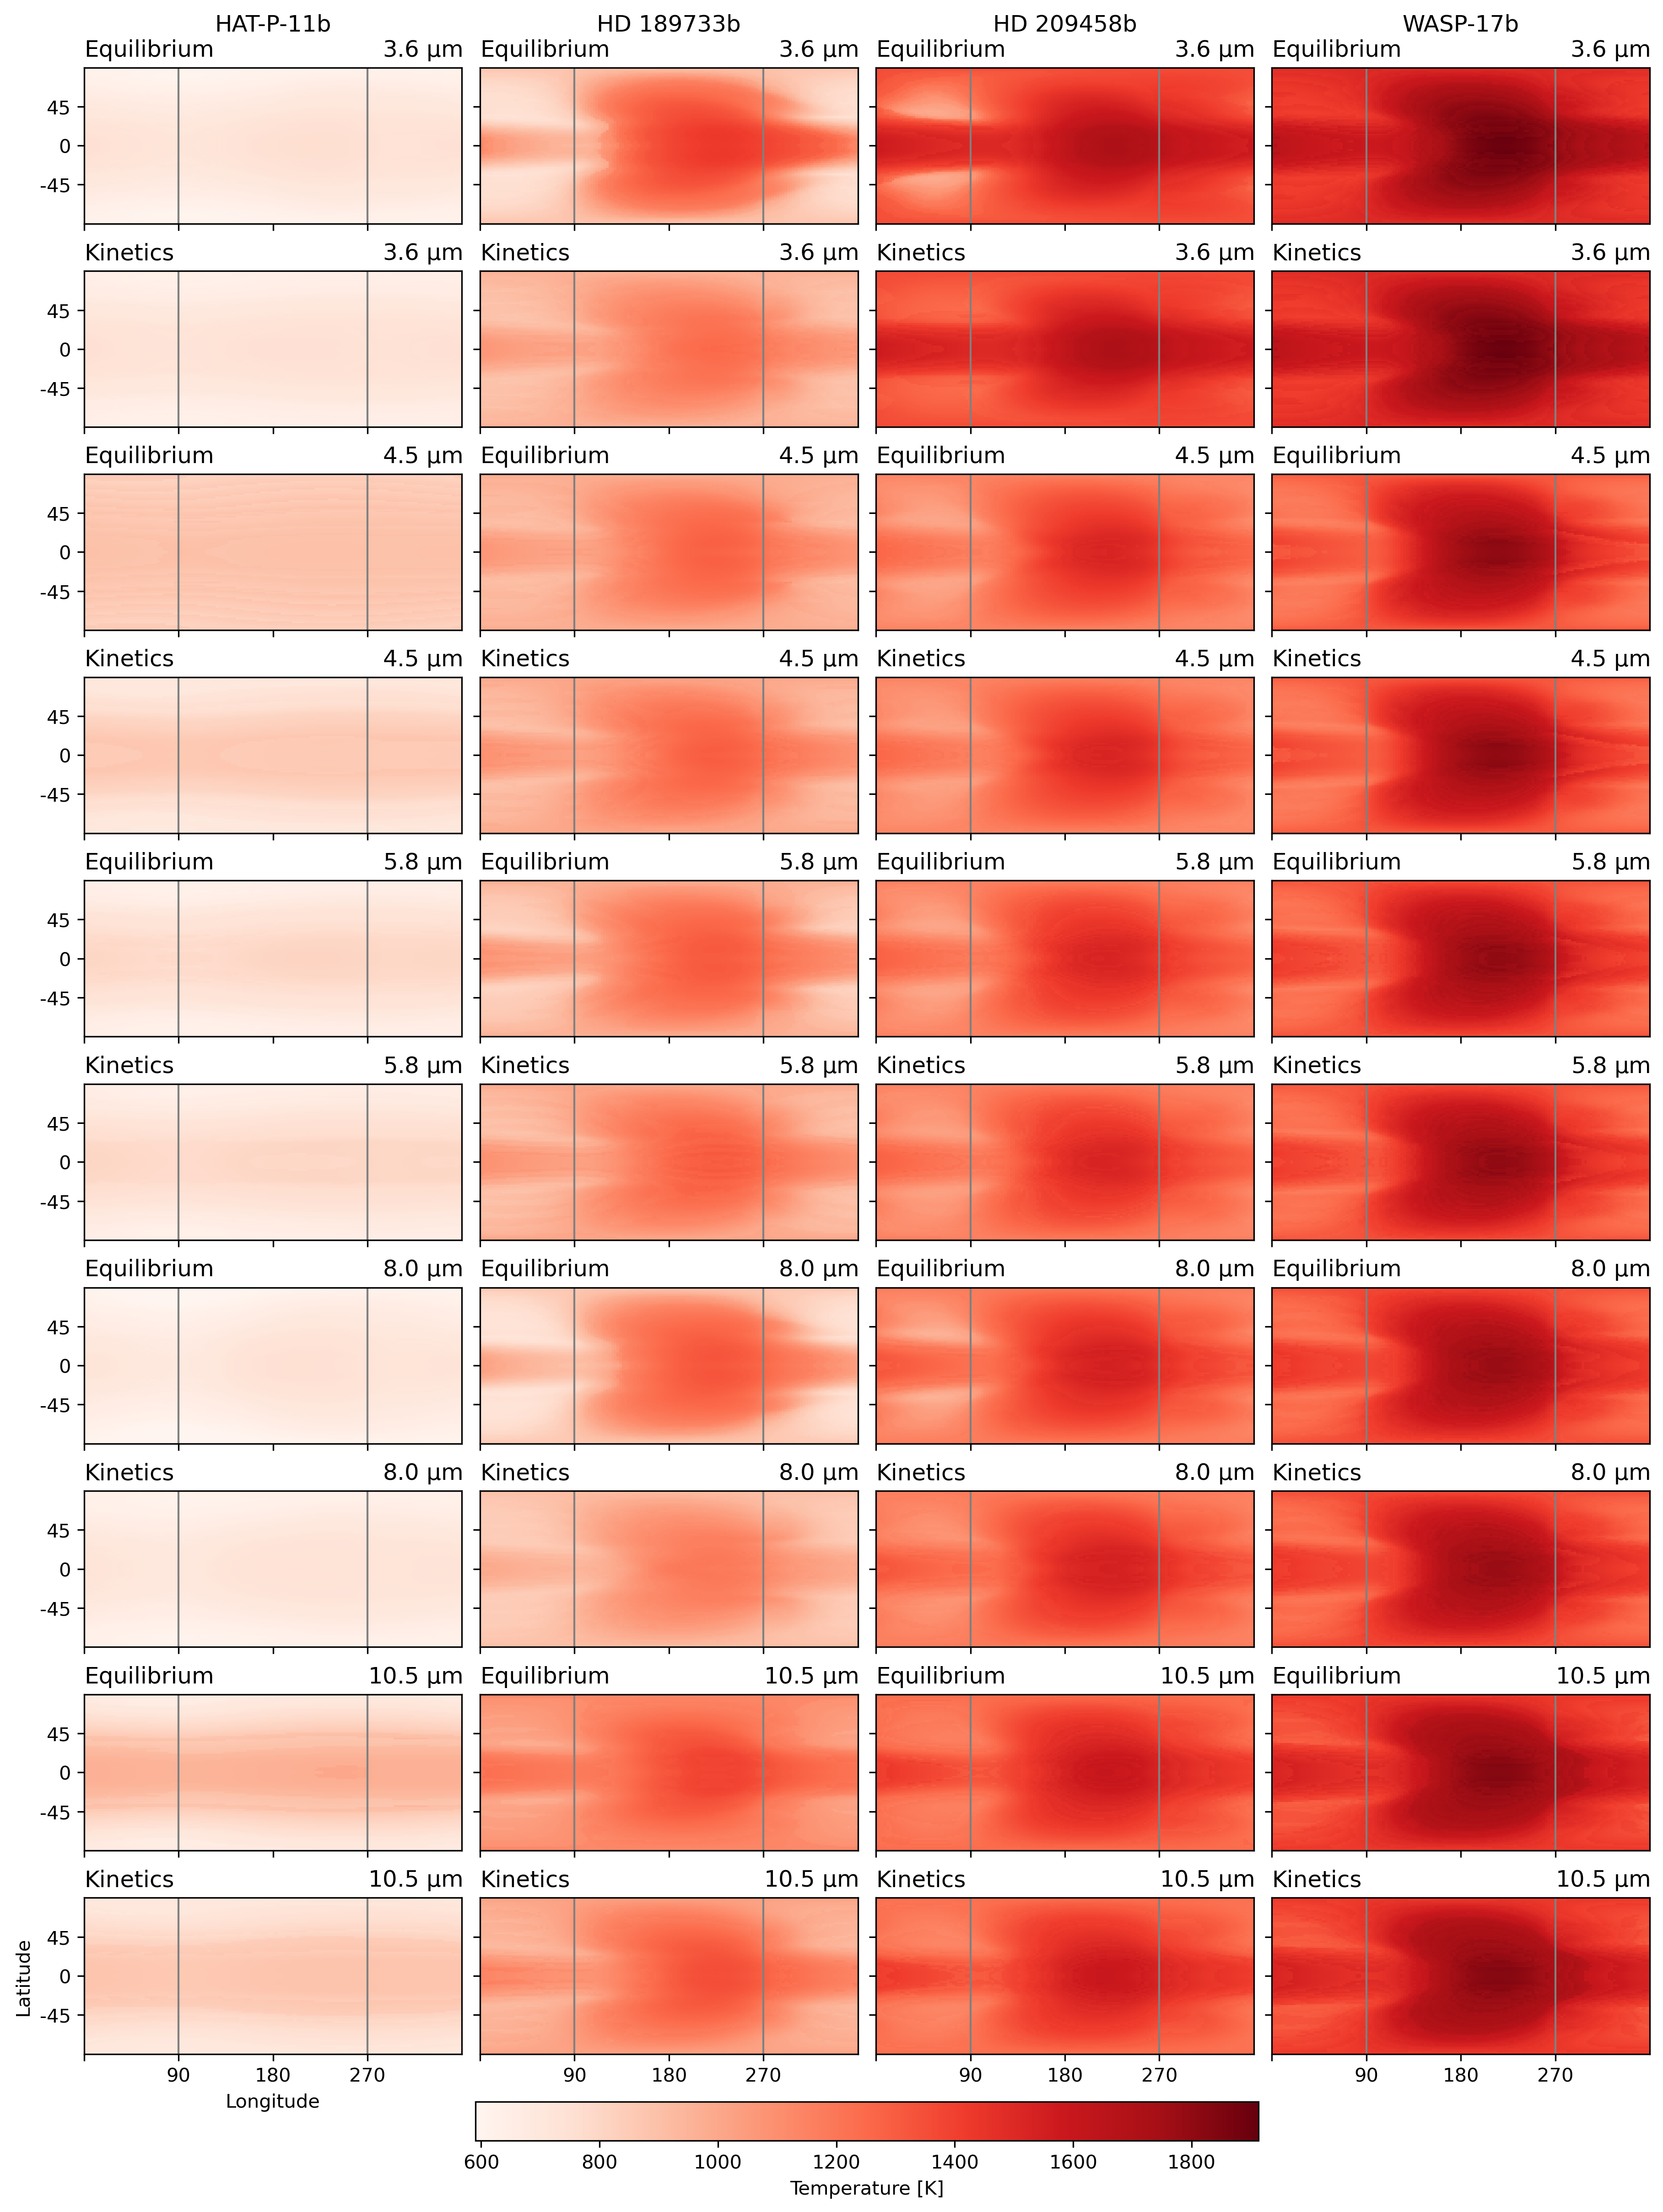

In [20]:
fig, axes = plt.subplots(
    figsize=(12, 16),
    nrows=10,
    ncols=4,
    sharex=True,
    sharey=True,
    facecolor="w",
    constrained_layout=True,
)
for planet, axcol in zip(PLANETS.keys(), axes.T):
    for (exp, band), ax in zip(
        [(exp, band) for band in BANDS.keys() for exp in ["equilibrium", "kinetics"]], axcol
    ):
        ax.set_title(f"{exp.capitalize()}", loc="left")
        ax.set_title(f"{band} $\mu$m", loc="right")
        p0 = ax.pcolormesh(
            lons,
            lats,
            vrbls[planet][exp][band]["temp"],
            vmin=bounds_by_var["temp"]["min"],
            vmax=bounds_by_var["temp"]["max"],
            **temp_kwargs,
        )
        if ax.get_subplotspec().is_first_row():
            ax.set_title(f"{PLANETS[planet]['tex']}\n", loc="center")
        if ax.get_subplotspec().is_last_row():
            if ax.get_subplotspec().is_first_col():
                ax.set_xlabel("Longitude")
                ax.set_ylabel("Latitude")
        ax.set_xticks(
            [
                0,
                90,
                180,
                270,
            ]
        )
        ax.set_xticklabels(
            [
                None,
                90,
                180,
                270,
            ]
        )
        ax.axvline(x=90, color="grey", linewidth=1)
        ax.axvline(x=270, color="grey", linewidth=1)
        ax.set_yticks([-45, 0, 45])
        ax.set_yticklabels([-45, 0, 45])
cbar = fig.colorbar(
    p0, ax=axes, label="Temperature [K]", orientation="horizontal", shrink=0.5, pad=-0.005
)
fig.savefig(
    path_to_results / "photosphere_spitzer" / f"temp_at_lw_norm_flux_con_func_of_unity.png",
    bbox_inches="tight",
)

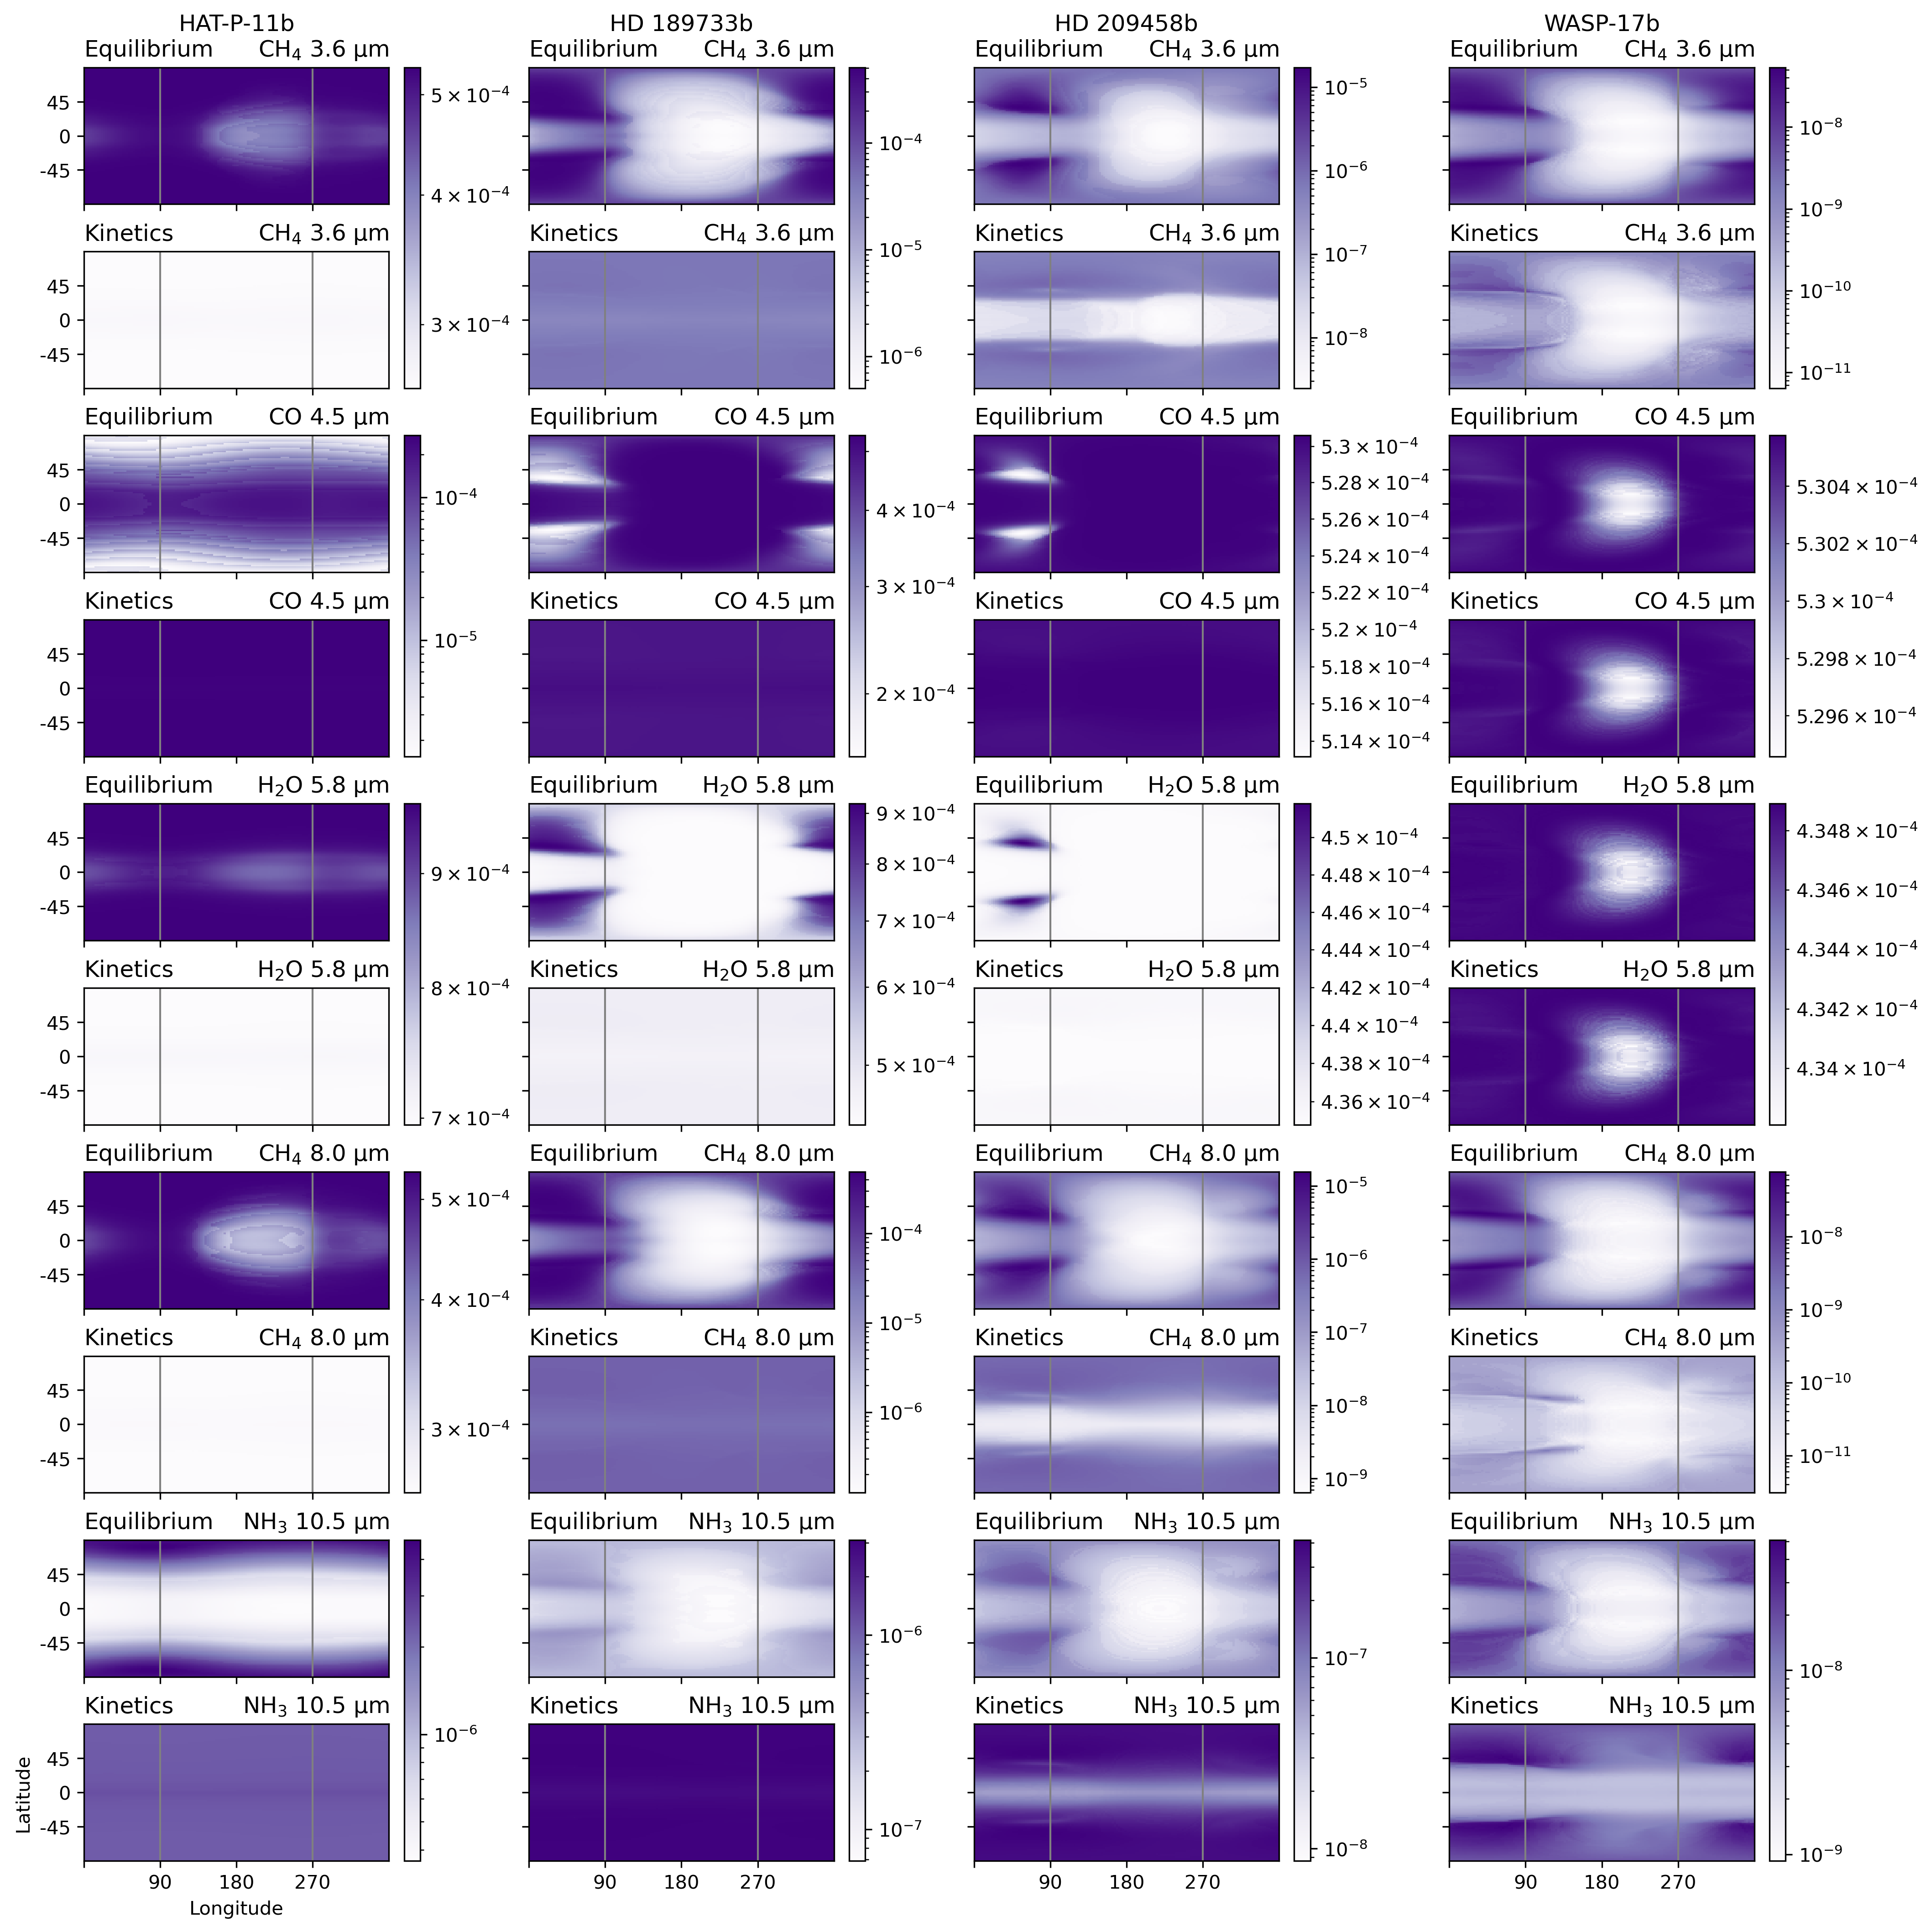

In [21]:
fig, axes = plt.subplots(
    figsize=(14, 14),
    nrows=10,
    ncols=4,
    sharex=True,
    sharey=True,
    facecolor="w",
    constrained_layout=True,
)
for planet, axcol in zip(PLANETS.keys(), axes.T):
    mappables = []
    for (exp, band), ax in zip(
        [(exp, band) for band in BANDS.keys() for exp in ["equilibrium", "kinetics"]], axcol
    ):
        # Find chemical species data
        chem = [i for i in vrbls[planet][exp][band].keys() if i not in ["pres", "temp"]][0]
        ax.set_title(f"{exp.capitalize()}", loc="left")
        ax.set_title(f"{GASES[chem.upper()]['tex']} {band} $\mu$m", loc="right")
        p0 = ax.pcolormesh(
            lons,
            lats,
            vrbls[planet][exp][band][chem],
            norm=LogNorm(
                vmin=bounds_by_planet[planet][band][chem]["min"],
                vmax=bounds_by_planet[planet][band][chem]["max"],
            ),
            **chem_kwargs,
        )
        mappables.append(p0)
        if ax.get_subplotspec().is_first_row():
            ax.set_title(f"{PLANETS[planet]['tex']}\n", loc="center")
        if ax.get_subplotspec().is_last_row():
            if ax.get_subplotspec().is_first_col():
                ax.set_xlabel("Longitude")
                ax.set_ylabel("Latitude")
        ax.set_xticks(
            [
                0,
                90,
                180,
                270,
            ]
        )
        ax.set_xticklabels(
            [
                None,
                90,
                180,
                270,
            ]
        )
        ax.axvline(x=90, color="grey", linewidth=1)
        ax.axvline(x=270, color="grey", linewidth=1)
        ax.set_yticks([-45, 0, 45])
        ax.set_yticklabels([-45, 0, 45])
    for axcol_pair, mppbl in zip(np.array_split(axcol, 5), np.array_split(mappables, 5)):
        cbar = fig.colorbar(mppbl[0], ax=axcol_pair, orientation="vertical")
fig.savefig(
    path_to_results / "photosphere_spitzer" / f"chem_at_lw_norm_flux_con_func_of_unity.png",
    bbox_inches="tight",
)